In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/AI/.kaggle/"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/AI/.kaggle

/content/drive/MyDrive/AI/.kaggle


In [4]:
!kaggle datasets download -d mariafrenti/age-prediction

100% 2.03G/2.03G [01:20<00:00, 32.4MB/s]
100% 2.03G/2.03G [01:20<00:00, 27.2MB/s]


In [6]:
!unzip age-prediction.zip
!ls

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: age_prediction_up/age_prediction/train/070/79502.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79589.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79660.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79733.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79774.jpg  
  inflating: age_prediction_up/age_prediction/train/070/80028.jpg  
  inflating: age_prediction_up/age_prediction/train/070/80607.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81012.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81131.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81329.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81604.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81811.jpg  
  inflating: age_prediction_up/age_prediction/train/070/82005.jpg  
  inflating: age_prediction_up/age_prediction/train/070/82162.jpg  
  inflating:

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn

In [8]:
image_dir = Path('/content/drive/MyDrive/AI/.kaggle/20-50') #tell python in which directory the training images are.
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int)
images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
images.head()

<ipython-input-8-af4066391dda>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int)


,Filepath,Age
0,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,35
1,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,47
2,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,48
3,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,31
4,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,20


Age: 21


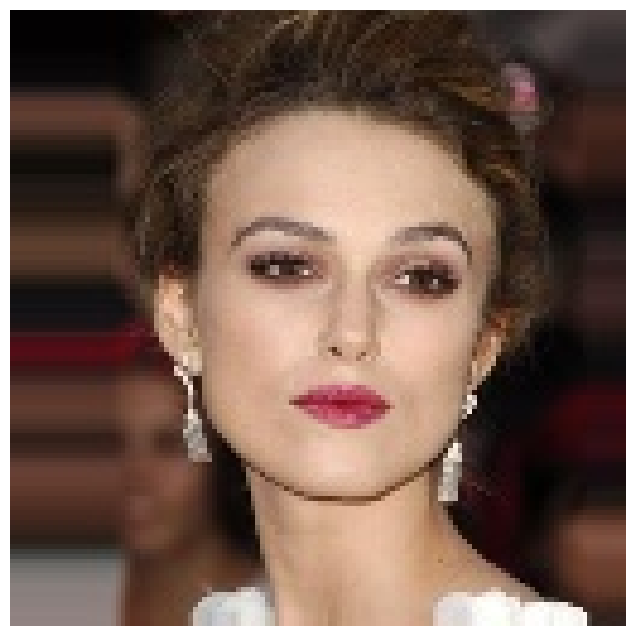

In [9]:
def visualize(image):
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(image)

#choose an image id to see its age
image_id = 35
image_example_path = images.iloc[image_id].Filepath
age = images.iloc[image_id].Age

print(f'Age: {age}')
image = cv2.imread(image_example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)


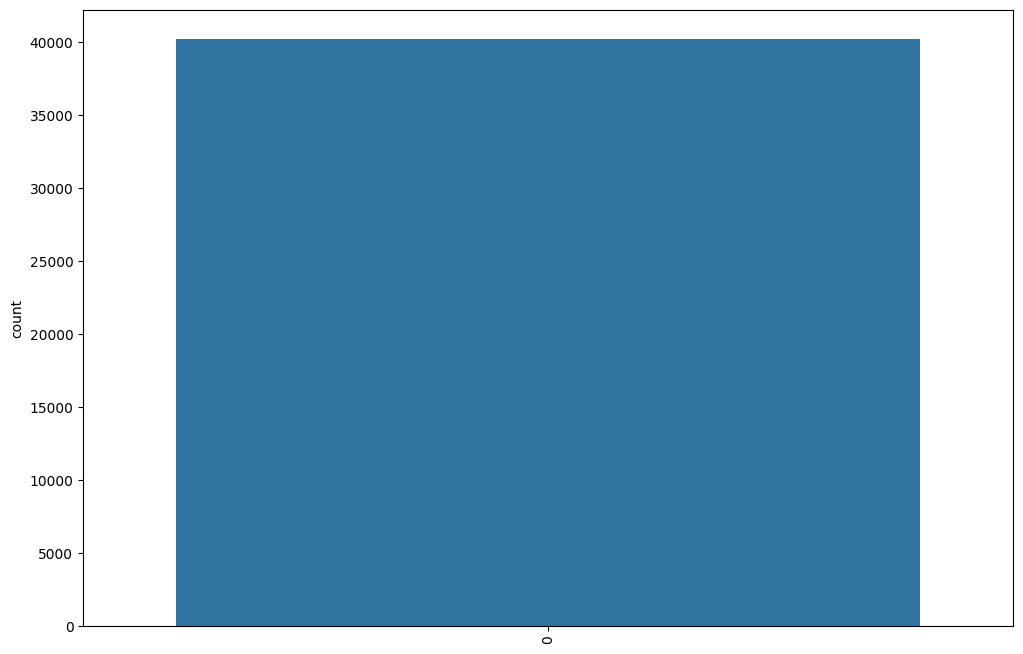

In [10]:
plt.figure(figsize=(12, 8))
sns.countplot(images.Age)
plt.xticks(rotation = 90)
plt.show()

In [11]:
images.Age = images.Age-20

In [12]:
images.Age.values

array([15, 27, 28, ..., 22,  4, 24])

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(images, test_size = 0.1, random_state = 1)
train, valid = train_test_split(train, test_size = 0.2, random_state = 1)

In [14]:
class ImageAgeDataset() : 
  def __init__(self , images) : 
    self.age = images.Age.values
    self.paths = images.Filepath.values 

  def __len__(self) : 
    return len(self.age)

  def __getitem__(self , item) : 
    out = dict()
    path = self.paths[item] 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image , dtype = float)
    out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255 
    out['y'] = torch.tensor(self.age[item], dtype= torch.long) #CrossEntropyLoss()'s forward(probs, y) function requires torch.long for y
    return out 

In [15]:
train_dataset = ImageAgeDataset(train) 
valid_dataset = ImageAgeDataset(valid)

In [16]:
type(train_dataset)

__main__.ImageAgeDataset

In [17]:
class AlexNetwork(nn.Module):
    def __init__(self, n_classes):
        super(AlexNetwork, self).__init__()
        self.n_classes = n_classes
        self.conv_1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 96,
            kernel_size = 11,
            stride = 4,
            padding = 50
        )
        self.pool_1 = nn.MaxPool2d(
        kernel_size = 3, 
        stride = 2,
        )
        self.conv_2 = nn.Conv2d(
            in_channels = 96,
            out_channels = 256,
            kernel_size = 5,
            stride = 1,
            padding = 2
        )  
        self.pool_2 = nn.MaxPool2d(
        kernel_size = 3, 
        stride = 2,
        )
        self.conv_3 = nn.Conv2d(
            in_channels = 256,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )  
        self.conv_4 = nn.Conv2d(
            in_channels = 384,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )  
        self.conv_5 = nn.Conv2d(
            in_channels = 384,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ) 
        self.pool_3 = nn.MaxPool2d(
        kernel_size = 3, 
        stride = 2,
        )
        self.nn = nn.Sequential(nn.Linear(in_features = 9216, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = self.n_classes),
                               )
    def forward(self, x):
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.pool_3(x)
        x = x.view(-1,9216)
        x = self.nn(x)
        return x

In [18]:
#hparams
DEVICE = 'cuda' 
BATCH_SIZE = 50
MAX_WAIT = 3
EPOCHS = 5
LR = 1e1

#---------------------
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = True ,
    num_workers = 8
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    num_workers = 8
)
#---------------------
model = AlexNetwork(31)
model.to(DEVICE)
#---------------------
loss_fn = nn.CrossEntropyLoss()
#---------------------
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
#---------------------
from tqdm.notebook import tqdm 
import numpy as np 
def train_step(model , optimizer , dataloader): 
  model.train()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    y_hat = model(x).to(DEVICE) #to apply model(x), x and model must be in the same place (device)
    loss = loss_fn(y_hat , y) #enough for y_hat and y to be in the same device
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  #total_loss.backward()
  #optimizer.step()
  #optimizer.zero_grad()
  return total_loss/len(dataloader)

def valid_step(model, dataloader): 
  model.eval()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    with torch.no_grad():
      y_hat = model(x).to(DEVICE)
      loss = loss_fn(y_hat , y) 
    total_loss += loss.item()
  return total_loss/len(dataloader)

def main(model , optimizer , train_dataloader , valid_dataloader ): 
  train_losses = []
  valid_losses = [] 
  min_valid_loss = np.inf 
  patience = 0 
  for epoch in range(EPOCHS): 
    train_loss = train_step(model , optimizer , train_dataloader)
    train_losses.append(train_loss)  
    valid_loss = valid_step(model , valid_dataloader)
    valid_losses.append(valid_loss)
    print(f'EPOCH = {epoch}')
    print(f'train_loss = {train_loss}')
    print(f'valid_loss = {valid_loss}')
    if valid_loss > min_valid_loss : 
      patience += 1 
    else: 
      min_valid_loss = valid_loss 
      patience = 0 

    if patience > MAX_WAIT : 
      print(f'EARLY STOPPING AT EPOCH = {epoch}')
      break 
  return train_losses , valid_losses

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
train_losses, valid_losses = main(
    model = model, 
    optimizer = optimizer, 
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader
)

  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

EPOCH = 0
train_loss = 4.213947009667861e+27
valid_loss = 2.712722823910229e+27


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

EPOCH = 1
train_loss = 2.1238811694963213e+27
valid_loss = 1.7135490078446195e+27


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

EPOCH = 2
train_loss = 1.5560375280804455e+27
valid_loss = 1.3074153815020776e+27


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

EPOCH = 3
train_loss = 1.4204646661378162e+27
valid_loss = 1.8117725625937683e+27


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

EPOCH = 4
train_loss = 1.428282802231843e+27
valid_loss = 1.5789762787502864e+27


In [20]:
test_dataset = ImageAgeDataset(test)

In [21]:
len(test_dataset)

4025

image 518 is
35 years old 
predicted 37 years old


<ipython-input-27-0233ab43c527>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat_id = softmax(model(test_dataset[id]['x'].to(DEVICE)))


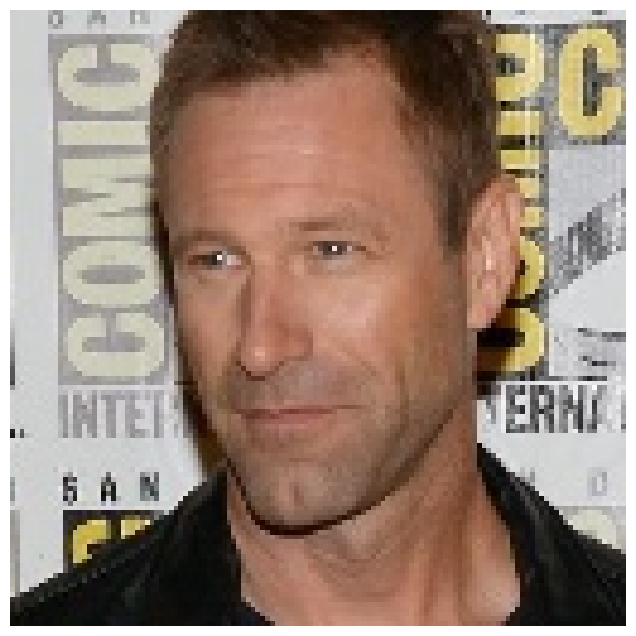

In [27]:
# play around.. choose an id from 0 to 4043 to test the model on :)
id = 518
softmax = nn.Softmax()
y_hat_id = softmax(model(test_dataset[id]['x'].to(DEVICE)))
def pred(x):
    for i in range(len(x[0])):
        if (x[0][i] == torch.max(x[0]).item()): 
            return i
true_age = train_dataset[id]['y'].item() + 20
print(f'image {id} is\n{true_age} years old \npredicted {pred(y_hat_id)+20} years old')
image = cv2.imread(test.iloc[id].Filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)